# Optimización de Parámetros - XGB

In [1]:
## Get current work directory to load all the custom modules
from pathlib import Path
import os
import sys
BASE_DIR = Path().absolute().resolve(strict=True).parent.parent.parent
if str(BASE_DIR) not in sys.path:
    sys.path.append(str(BASE_DIR))

In [2]:
DATA_PATH = os.path.join(BASE_DIR, 'data', 'gruas')
print(DATA_PATH)

/workspace/Externos/TimeSeries/BenchMark/data/gruas


In [3]:
import pandas as pd


In [4]:
import optuna
import datetime

In [5]:
from modulos.arima.gruas.general import format_timeseries, show_results_r2, arima_forecasting, total_forecasting, show_optimizer_results
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score

from modulos.LR.gruas.generals import make_lags
from modulos.DirRec.gruas.optimizer import XGBOptimizer

In [6]:
data = pd.read_csv(os.path.join(DATA_PATH, 'producto.csv'), parse_dates=['Periodo'])
data.head()

,idArticulo,ventas,DescProducto,Periodo
0,tuerc,7,TUERCA,2021-05-01
1,tuerc,5,TUERCA,2020-12-01
2,tuerc,1,TUERCA,2020-11-01
3,tuerc,11,TUERCA,2020-09-01
4,tuerc,4,TUERCA,2020-06-01


In [7]:
# Pivotando las tablas y llenando de ceros las ventas que no existen.
df_time = format_timeseries(data)
df_time.tail()

idArticulo,arandel,bateriascanrec,filtrodeair,filtrodepresio,filtroderetorn,pern,soport,tuerc
Periodo,,,,,,,,
2021-06-01,0.0,0.0,2.0,2.0,4.0,0.0,0.0,0.0
2021-07-01,0.0,1.0,2.0,2.0,2.0,0.0,1.0,0.0
2021-08-01,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
2021-09-01,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0
2021-10-01,0.0,1.0,2.0,2.0,1.0,0.0,0.0,0.0


## Optimizando un solo Producto

## Baseline LR

In [8]:
idArticulo = 'filtrodeair'
ts = df_time[idArticulo].copy()

# Lag features
n_lags = 3
X = make_lags(ts, n_lags)
# Multistep targets
y = pd.DataFrame({
    'y': ts,
})

y, X = y.align(X, join='inner', axis=0)

In [9]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

In [10]:
model = XGBRegressor()
scores = cross_val_score(model, X, y, cv=10, scoring='r2')
print(f"Cross validation results r2: {scores.mean()} ")
model.fit(X, y)

Cross validation results r2: -0.3172071742830512 


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [11]:
y_fit = pd.DataFrame(model.predict(X), index=X.index, columns=y.columns)
#y_pred = pd.DataFrame(model.predict(X_test), index=X_test.index, columns=y.columns)

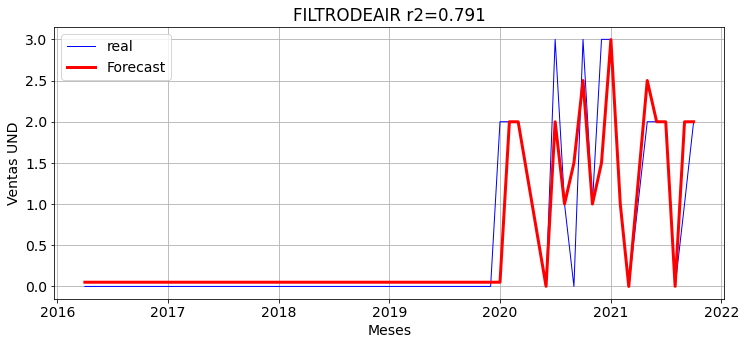

0.7912786309032056

In [12]:
show_results_r2(df_time, y_fit, idArticulo)


# Optimizar todos los Productos        
        

In [13]:
optimizer = XGBOptimizer(df_time, iterations=100, data_path= DATA_PATH , model='XGB', subpath = 'DirRec')
optimizer.run( chunk_size=4)

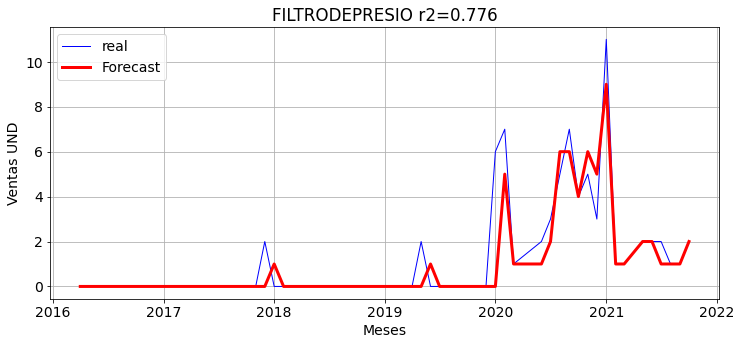

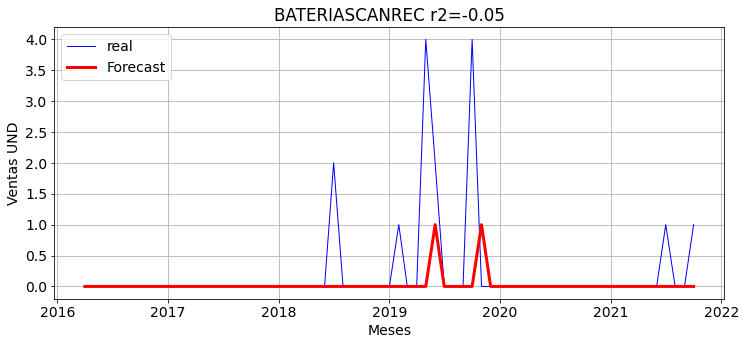

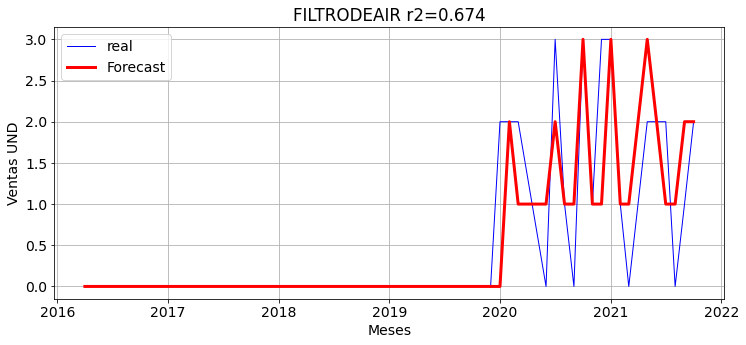

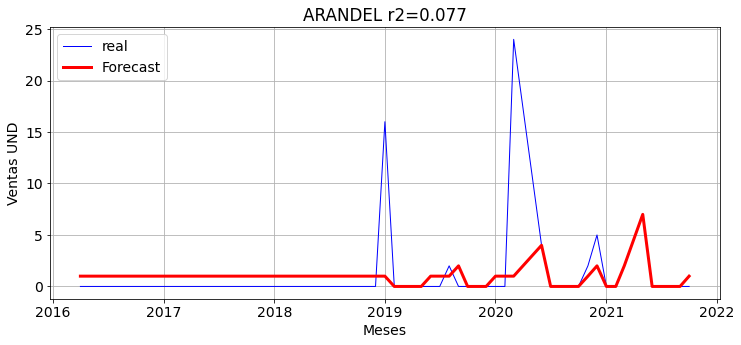

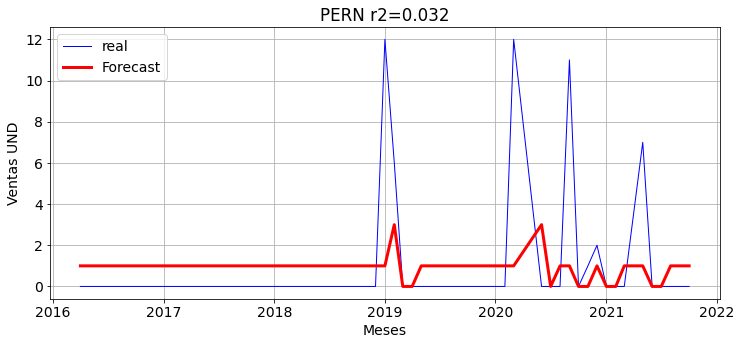

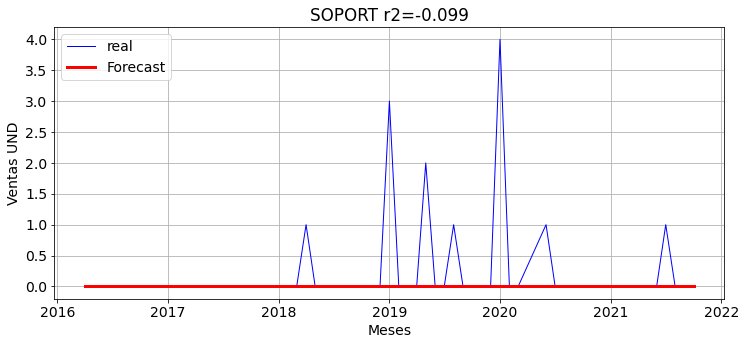

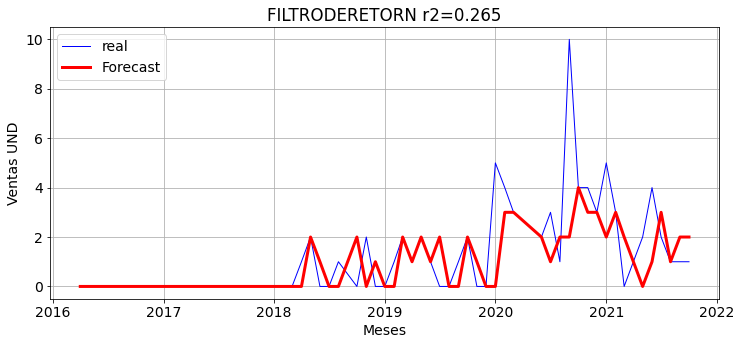

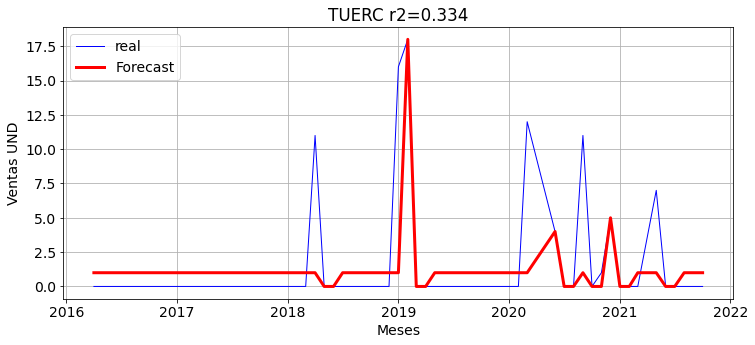

In [14]:
optimizer.print_results()

# Optimizer -  Evolution on time

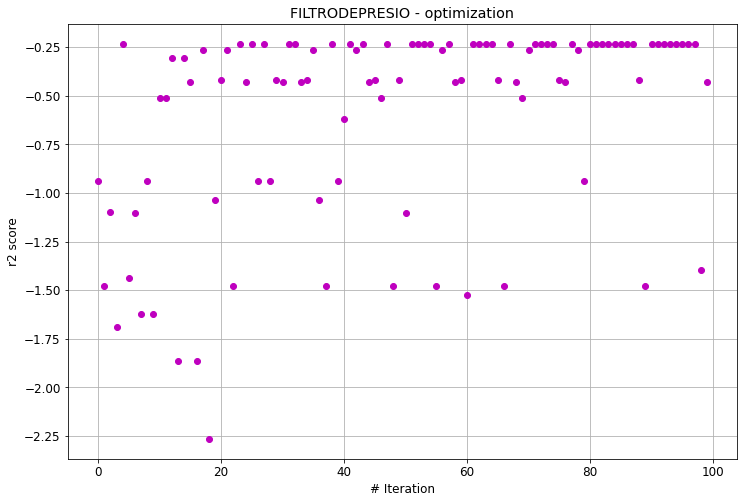

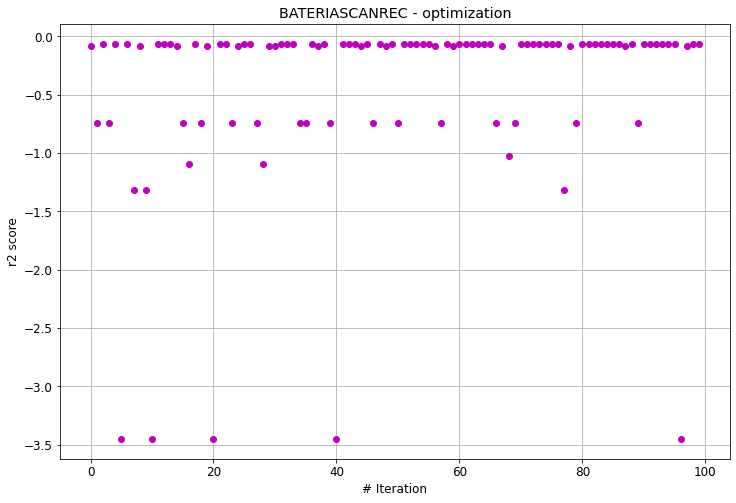

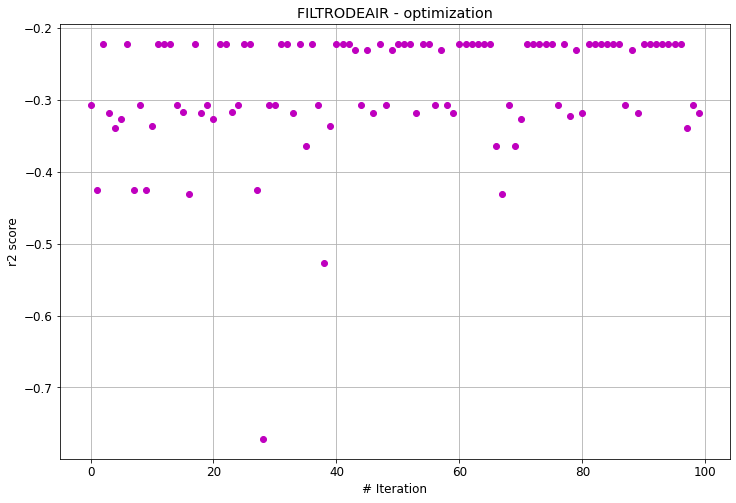

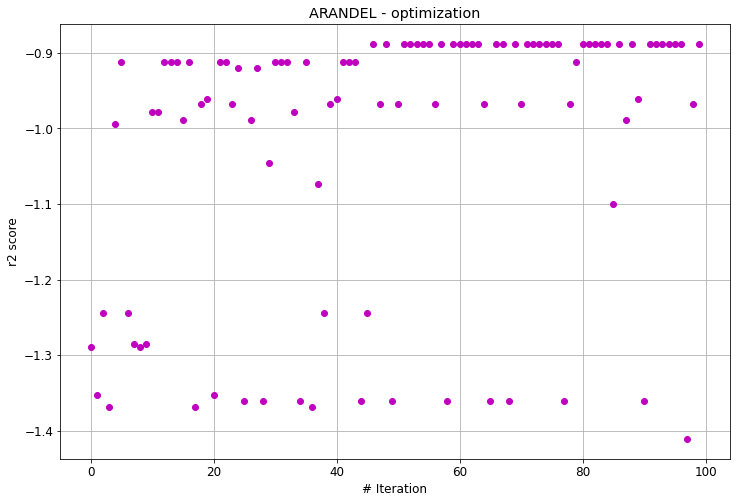

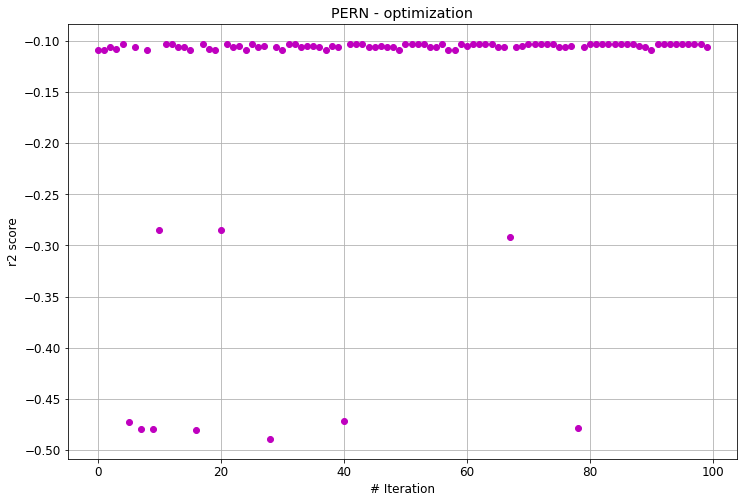

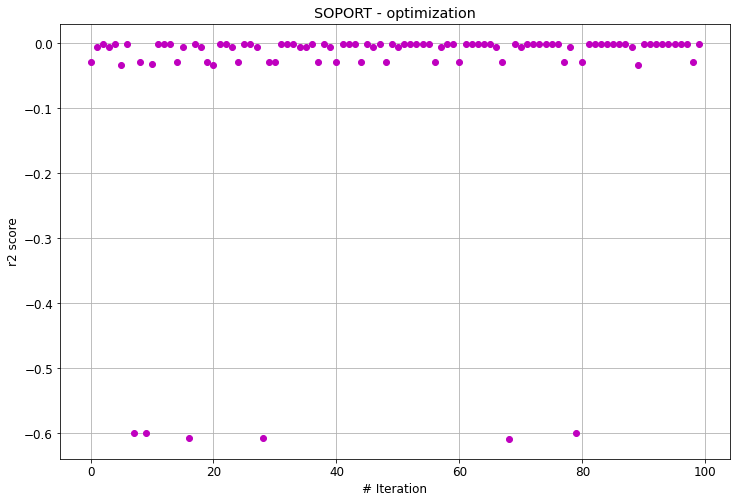

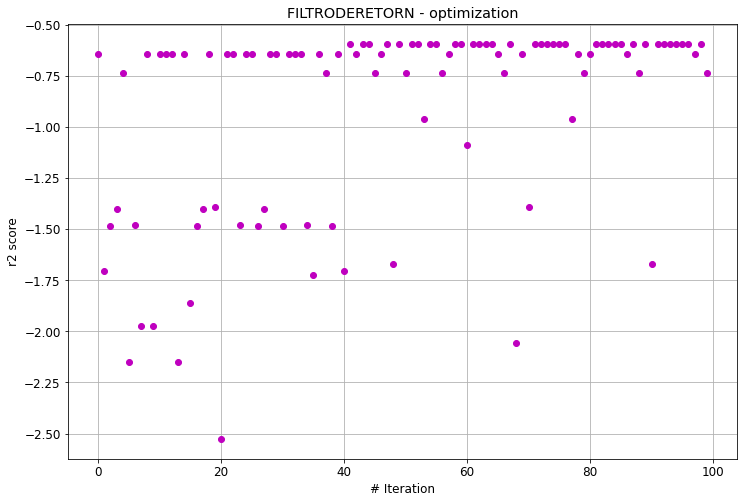

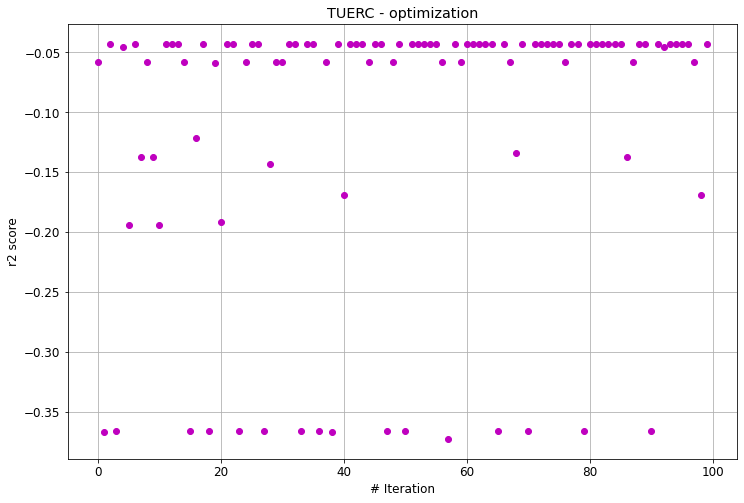

In [15]:
optimizer.print_optimizer_results()

In [16]:
optimizer.results

,idArticulo,hyper,r2,model
0,filtrodepresio,"{'n_lags': 2, 'max_depth': 1, 'random_state': ...",-0.232181,XGB
1,bateriascanrec,"{'n_lags': 2, 'max_depth': 5, 'random_state': ...",-0.062079,XGB
2,filtrodeair,"{'n_lags': 2, 'max_depth': 4, 'random_state': ...",-0.221788,XGB
3,arandel,"{'n_lags': 4, 'max_depth': 6, 'random_state': ...",-0.887805,XGB
4,pern,"{'n_lags': 2, 'max_depth': 1, 'random_state': ...",-0.102898,XGB
5,soport,"{'n_lags': 2, 'max_depth': 5, 'random_state': ...",-0.000603,XGB
6,filtroderetorn,"{'n_lags': 1, 'max_depth': 1, 'random_state': ...",-0.592109,XGB
7,tuerc,"{'n_lags': 2, 'max_depth': 4, 'random_state': ...",-0.042743,XGB
